In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim

from model import Opt_GMM_Mapper
from model import Trainer
from model import Soft_Mapper

from scripts.analysis_msbb import analysis_braak
torch.manual_seed(0) #fix seed
np.random.seed(42)

def Lor_distance(X, c): #X: n*dim c: 1*dim
    # centering
    X = X-c
    # add x_0
    x0 =  torch.sqrt(torch.norm(X, p=2, dim=1)**2 + 1)
    X = torch.cat((x0.unsqueeze(1), X), dim=-1)

    g = torch.eye(X.size()[1],dtype=float)
    g[0,0] = -1
    term1 = torch.matmul(X,g)
    r = torch.matmul(term1, X.T)
    dis = torch.acosh(-r)
    #dis.fill_diagonal_(fill_value=0)
    return dis

def mean_lor_distance(X):
    dis_list =[]
    for i in range(X.size()[0]):
        dis_list.append(Lor_distance(X, X[i,:]))
    dis_list = torch.stack(dis_list)
    #dis = torch.mean(dis_list, dim=0)
    dis = torch.mean(dis_list, dim=0) #/torch.std(dis_list, dim=0)
    dis.fill_diagonal_(0.)
    return dis

def matrix_lor_distance(X):
    dis_list =[]
    for i in range(X.size()[0]):
        dis_list.append(Lor_distance(X, X[i,:]))

    dis_list = torch.stack(dis_list) #n*n*n
    n = dis_list.shape[0]
    distance_matrix = torch.zeros((n, n))
    
    for i in range(n):
        for j in range(i+1, n):
            distance = torch.norm(dis_list[i] - dis_list[j], p=2)
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
    return distance_matrix

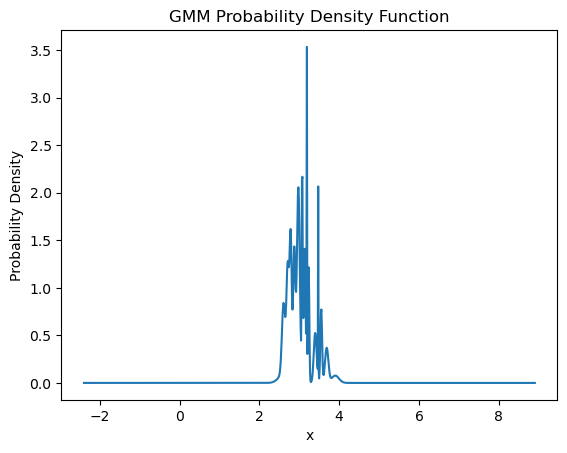

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


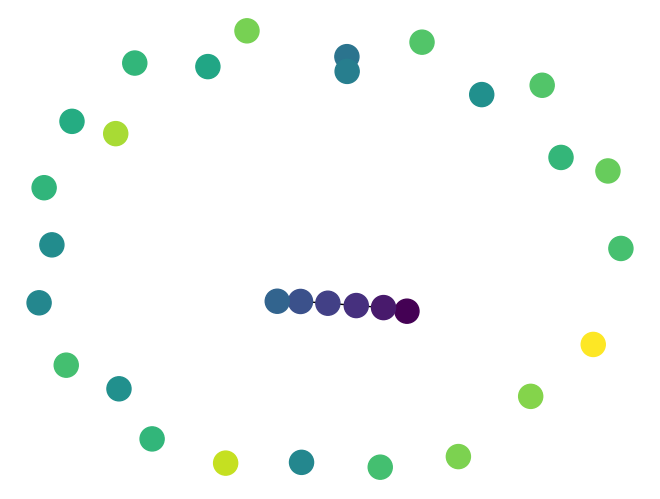

100%|██████████| 500/500 [00:13<00:00, 37.37it/s]


loss: -3.267951006032038
topo_loss: -4.726876166656767
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


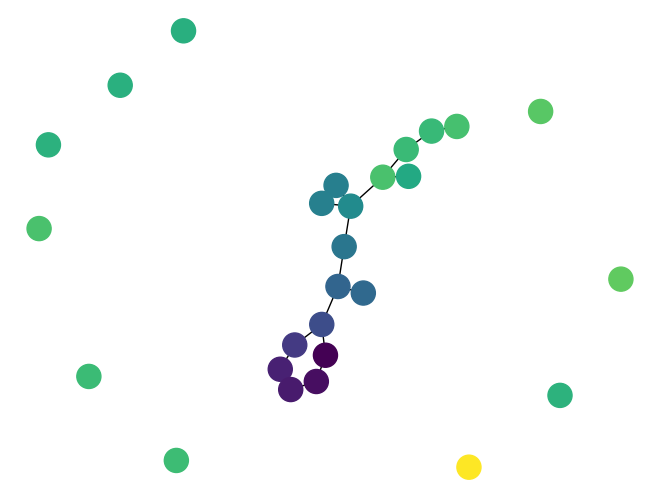

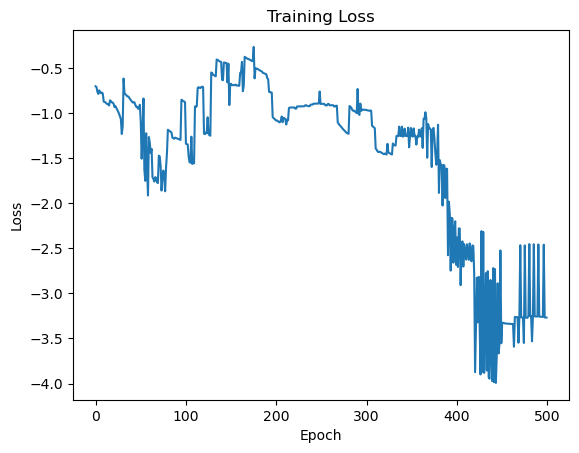

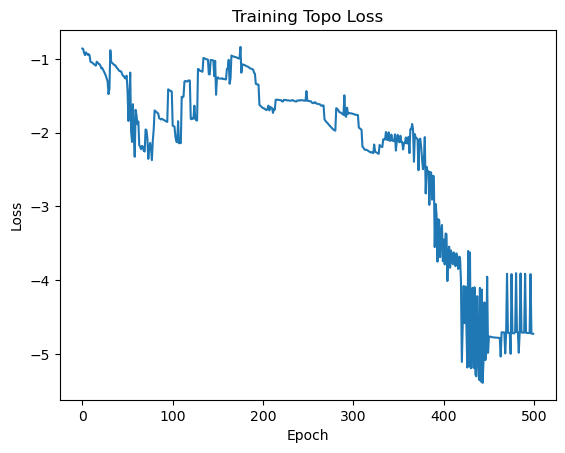

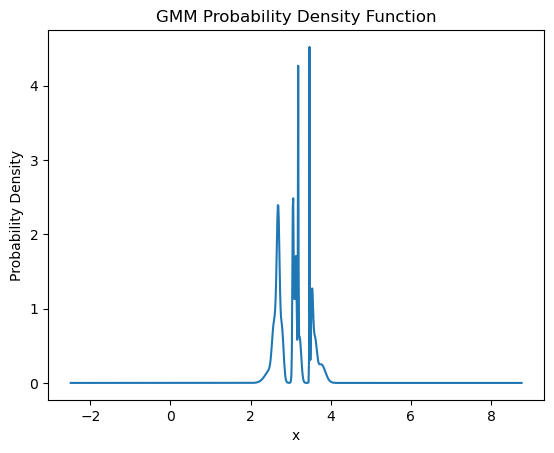

215
[10 21 31 39 21 21 50]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


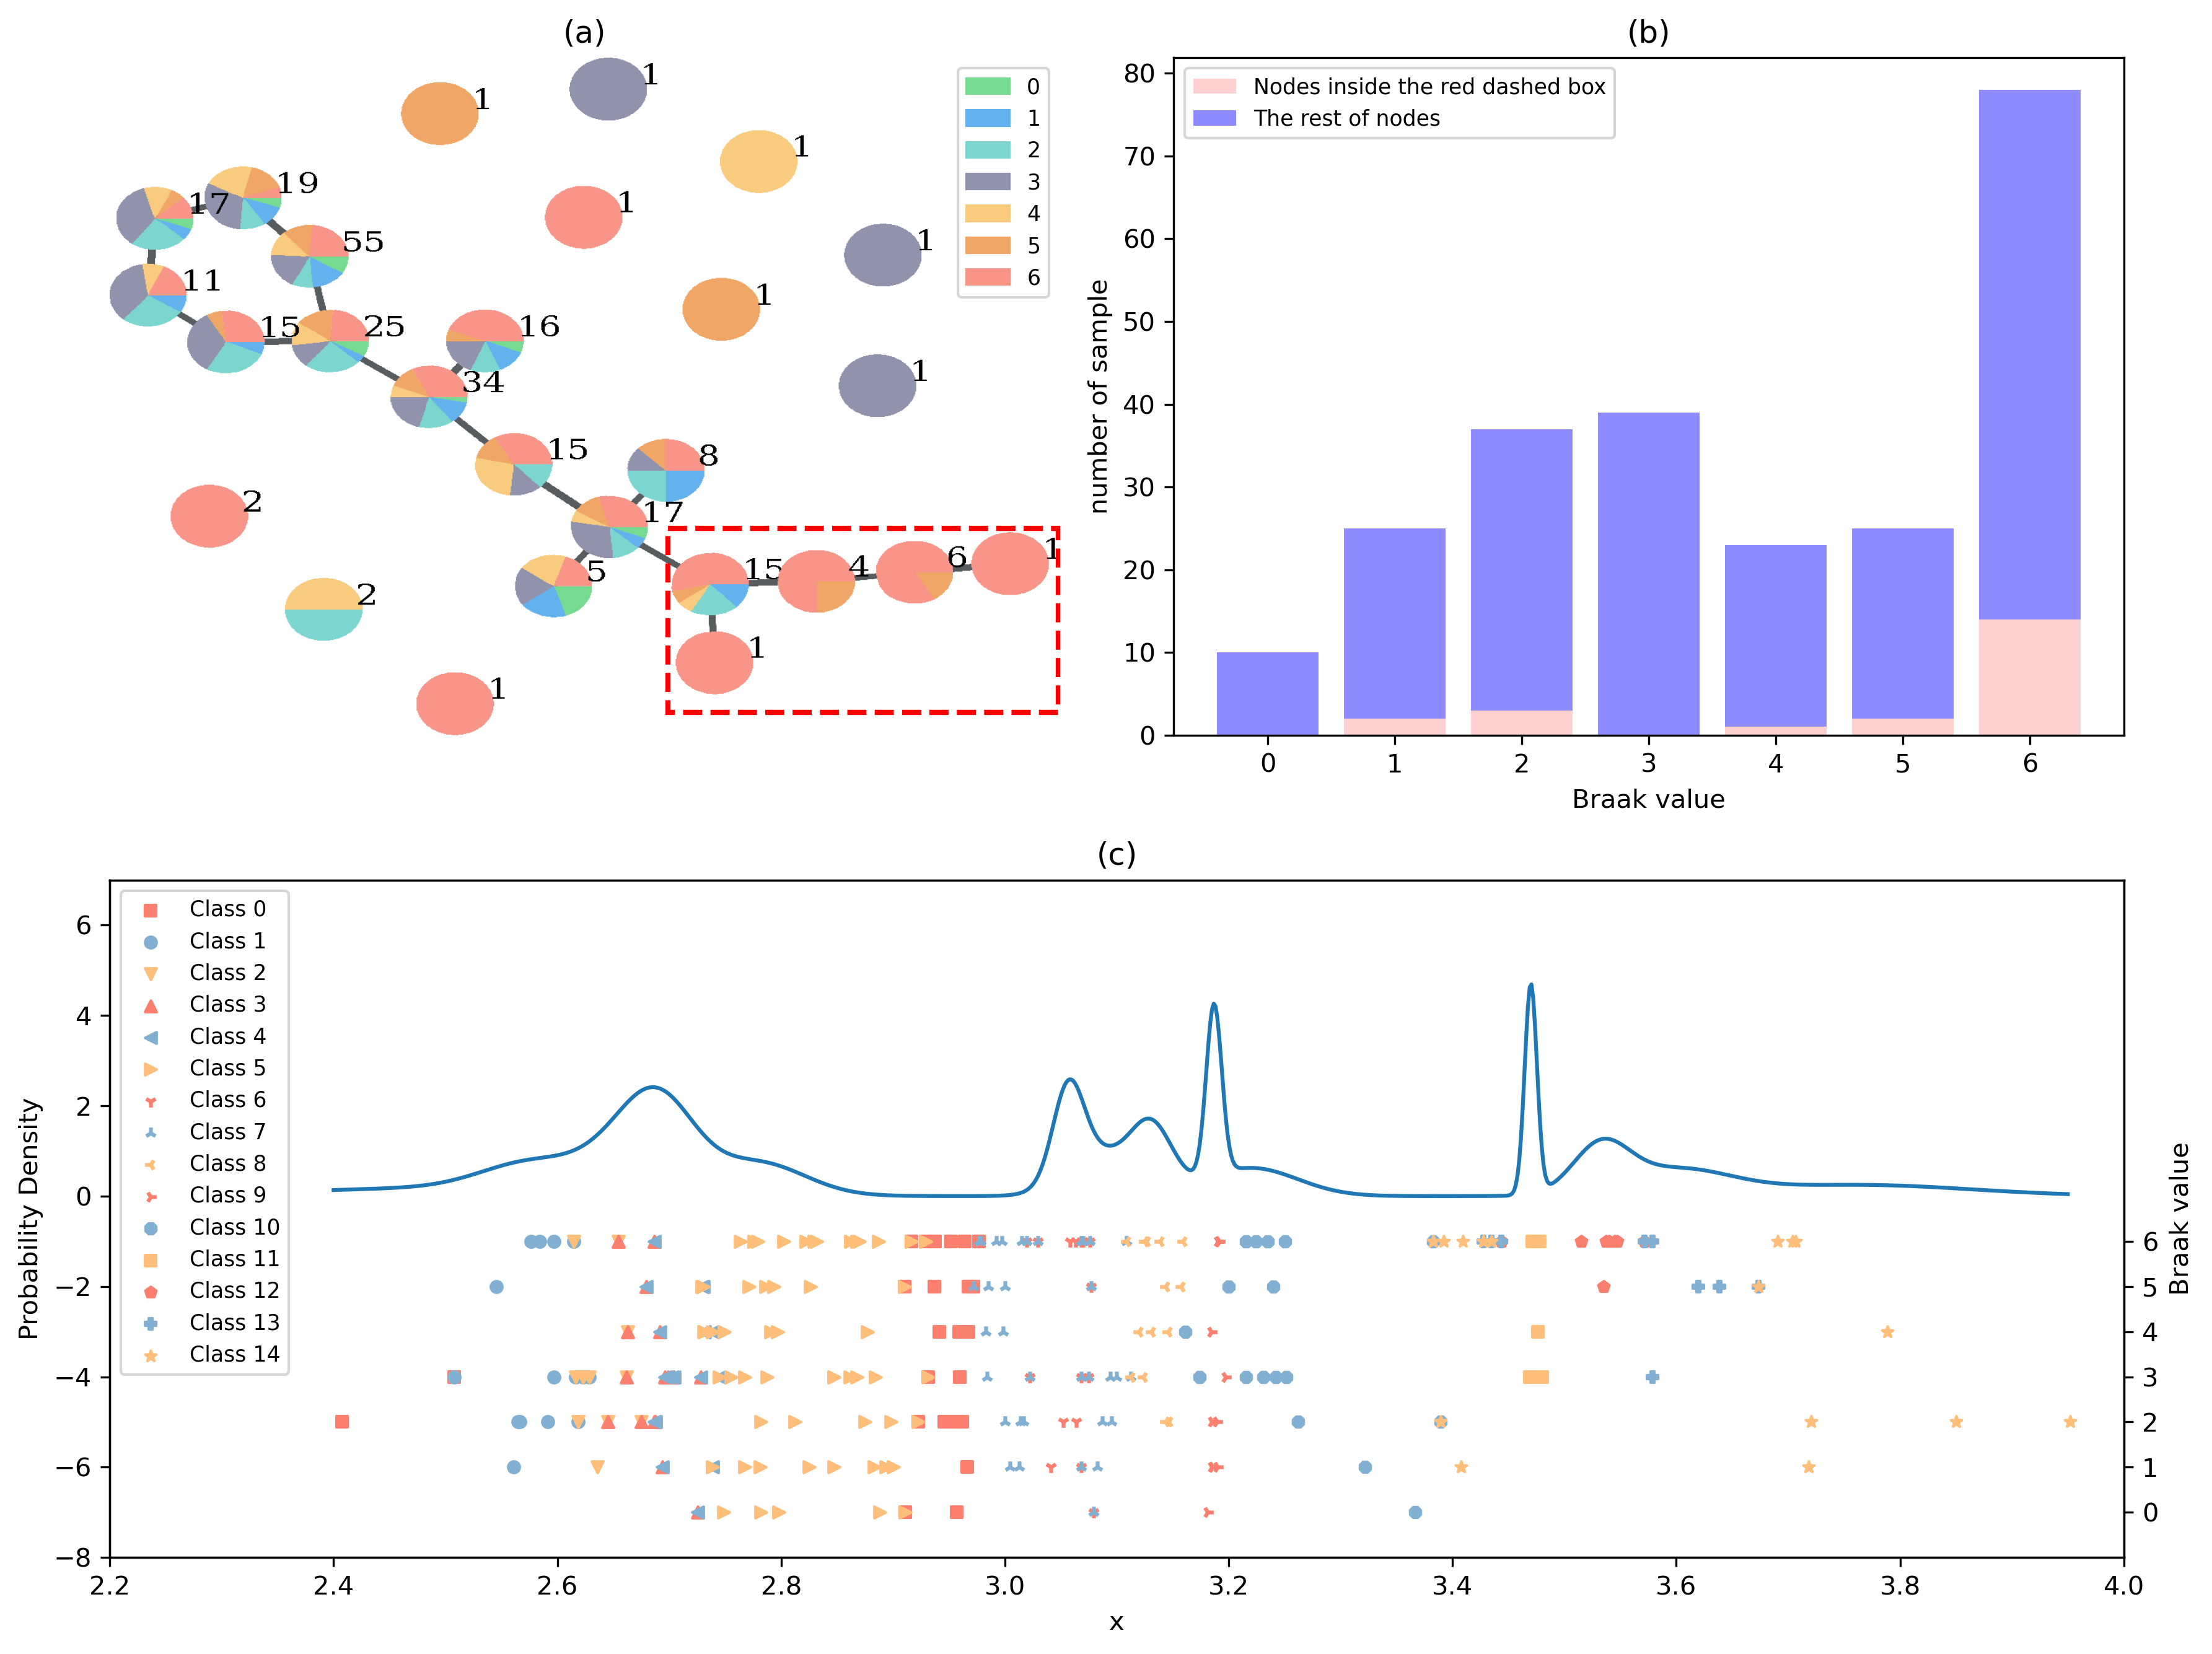

###########
Power_divergenceResult(statistic=18.695751989945542, pvalue=0.00470954013019232)
Have difference!!!


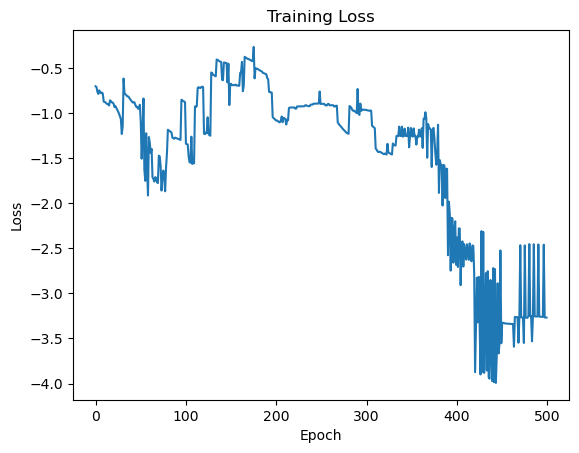

In [5]:
data_path = "data/36_top_gene.csv"
df = pd.read_csv(data_path,index_col=0)
data = np.array(df)
data = torch.tensor(data,dtype=float)
dis_matrix = mean_lor_distance(data)
projected_data = dis_matrix.mean(dim = 0)
projected_data = projected_data.view(len(projected_data),1)

# GMM initialization
n_comp = 15 #20
num_step = 500 # 450 500
l1 = 1
l2 = 1


cl = AgglomerativeClustering(distance_threshold=3.13, linkage='single',
                        metric='precomputed', n_clusters=None)

gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 10,
                      max_iter= 1000,tol=1e-4,random_state = 0 )

gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)
m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights, type = "distance matrix")
m.draw()
init_scheme = m.forward(projected_data, dis_matrix, cl)

# mapper before optimization
before_list = m.mode_filtration_f.detach().numpy()
mapper = Soft_Mapper.GMM_Soft_Mapper(init_scheme, cl, data = dis_matrix, projected_data =projected_data,path='figures',name = 'MSBB_36',format = 'eps',type="distance matrix")
G_mode_before = mapper.mode(save_fig= False)

optimizer = optim.SGD(m.parameters(), lr=0.0001, weight_decay=1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=450, gamma=0.1) #150

# train
train = Trainer(m, cl, num_step, optimizer, scheduler)
train.fit(dis_matrix, projected_data, l1, l2)
train.analysis()

# mapper after optimization
import networkx as nx
after_list = m.mode_filtration_f.detach().numpy()
G_mode_after = train.G_mode

clusters = train.mode_clusters

good_nodes = [11,15,16,6,22]

pos_list = [[ 3.03368299, -3.46388611], [-4.50585725, -4.72927214], [-3.13806622,  1.38346121], [11.82982347, -2.2245166 ], [  5.79949949, -10.42939218], [ 9.16797143, -8.42757858], 
            [8.07549389, 3.2618482 ], [-0.57541149,  3.96272112], [-2.38424855, -7.42230883], [-0.42753119, -3.46258944], [ 3.6761236 , -0.05294675], [10.46030098,  3.18812343], 
            [ 2.02884645, -9.75385544], [ 8.32857262, -4.33903805], [11.9512966 , -5.83826541], [8.1789573 , 5.43586192], [14.8,  2.7], [-4.35717844, -6.85529748], 
            [ 1.78430883, -1.91964732], [-0.88962258, -5.80291999], [5.82439687, 1.68073967], [-2.76986779, -3.43940053], [12.65556007,  2.9351866 ], [2.36575412, 6.57068134], 
            [ 5.24965958, -6.88746489], [4.57140821, 3.31315579], [7.08707343, 0.11847304]]
analysis_braak(G_mode_after, train, data_path, projected_data, good_nodes, (2.2,4),(-8, 7),
                pos_list=pos_list, rect_pos=(640,667,448,260)
                ,text_pos=[-0.3,-2.],name = "figures/36")
plt.show()


# loss plot
plt.plot(train.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.savefig('figures/36_loss.eps', bbox_inches='tight')
plt.show()


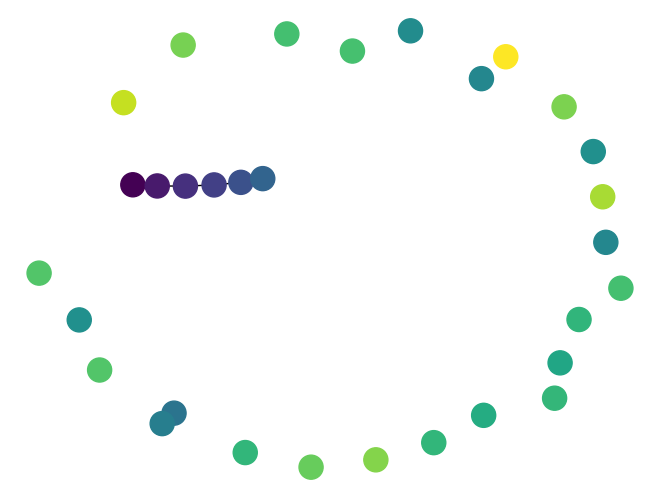

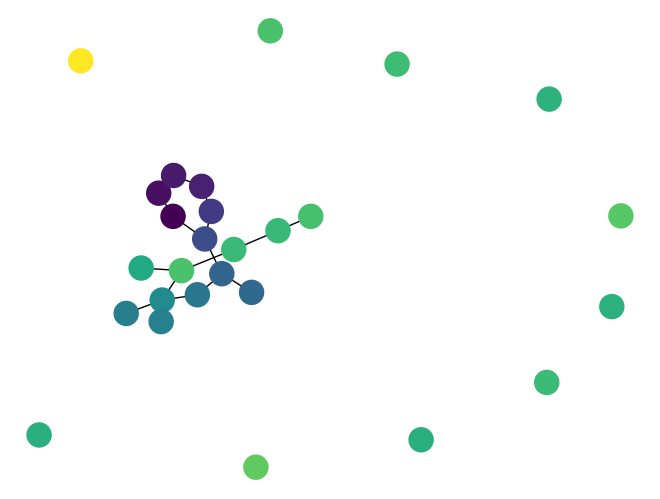

In [6]:
nx.draw(G_mode_before, 
        node_color=before_list
        )  
plt.savefig("figures/36_before.eps")
plt.show()

nx.draw(G_mode_after, 
        node_color=after_list,
    )  
plt.savefig("figures/36_after.eps")
plt.show()